In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import tensorflow as tf
import datetime as dt
import yfinance as yf
import seaborn as sns
import prophet as pt
import time
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
from vnstock import *

sns.set_style('whitegrid')
plt.style.use("default")
yf.pdr_override()
%matplotlib inline


In [60]:
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365 * 1)
df = pdr.get_data_yahoo('AAPL', start_date, end_date)
display(df.head())


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-24,147.190002,150.229996,146.000000,149.449997,148.568619,75981900
2022-10-25,150.089996,152.490005,149.360001,152.339996,151.441589,74732300
2022-10-26,150.960007,151.990005,148.039993,149.350006,148.469223,88194300
2022-10-27,148.070007,149.050003,144.130005,144.800003,143.946060,109180200
2022-10-28,148.199997,157.500000,147.820007,155.740005,154.821548,164762400


In [21]:
# df = pd.DataFrame(listing_companies())
# search_word = 'mobile'
# result = df[df['organName'].str.contains(search_word)]
# print(result)


In [22]:
# company_overview('VIC')


In [23]:
# df = stock_historical_data("VIC", "2020-01-01", "2023-09-30", "1D")
# df = pd.DataFrame(df)
# df


In [24]:
class DeepEvolutionStrategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def getWeights(self):
        return self.weights

    def train(self, epoch=100, print_every=1):
            lasttime = time.time()
            for i in range(epoch):
                population = []
                rewards = np.zeros(self.population_size)
                for k in range(self.population_size):
                    x = []
                    for w in self.weights:
                        x.append(np.random.randn(*w.shape))
                    population.append(x)
                for k in range(self.population_size):
                    weights_population = self._get_weight_from_population(
                        self.weights, population[k]
                    )
                    rewards[k] = self.reward_function(weights_population)
                rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
                for index, w in enumerate(self.weights):
                    A = np.array([p[index] for p in population])
                    self.weights[index] = (
                        w
                        + self.learning_rate
                        / (self.population_size * self.sigma)
                        * np.dot(A.T, rewards).T
                    )
                if (i + 1) % print_every == 0:
                    print(
                        f'Training Epoch {i + 1}. Final Reward: {self.reward_function(self.weights)}'
                    )
            print('=====================================')
            print(f'Training Time: {time.time() - lasttime} seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def getWeights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

    def save_model(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self.weights, file)

    def load_model(self, filename):
        with open(filename, 'rb') as file:
            self.weights = pickle.load(file)


In [25]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, window_size, trend, skip, initial_money):
        self.model = model
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.es = DeepEvolutionStrategy(
            self.model.getWeights(),
            self.getReward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])

    def getState(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def getReward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.getState(0)
        inventory = []
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.getState(t + 1)

            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= close[t]

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = next_state
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every=checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = self.getState(0)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.getState(t + 1)

            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('Day %s > Buy 1 share at price %s, Total Asset %s' % (
                    str(t).rjust(3),
                    str("%.5f" % self.trend[t]).rjust(10),
                    str("%.3f" % initial_money).rjust(10)
                ))

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print('Day %s > Sell 1 share at price %s, Total Asset %s > Profit %s %%' % (
                    str(t).rjust(3),
                    str("%.5f" % close[t]).rjust(10),
                    str("%.3f" % initial_money).rjust(10),
                    str("%.2f" % invest).rjust(5)
                ))
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest


In [26]:
# close = df["close"].tolist()
close = df.Close.values.tolist()
window_size = 30
skip = 1
initial_money = 10000


In [27]:
# model.load_model('D:\Time-series-forecasting\model\deepES_model_AAPL.hdf5')


In [28]:
model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(model = model,
              window_size = window_size,
              trend = close,
              skip = skip,
              initial_money = initial_money)
agent.fit(iterations = 500, checkpoint = 100)

model.save_model('D:\Time-series-forecasting\model\deepES_model_AAPL_10y')


Training Epoch 100. Final Reward: 5.041400680541992
Training Epoch 200. Final Reward: 8.106300430297852
Training Epoch 300. Final Reward: 10.872300643920898
Training Epoch 400. Final Reward: 11.347400894165037
Training Epoch 500. Final Reward: 12.072900619506836
Training Time: 491.0645081996918 seconds


In [29]:
states_buy, states_sell, total_gains, invest = agent.buy()


Day   1 > Buy 1 share at price  152.34000, Total Asset   9847.660
Day   2 > Sell 1 share at price  149.35001, Total Asset   9997.010 > Profit -1.96 %
Day  10 > Buy 1 share at price  138.92000, Total Asset   9858.090
Day  11 > Buy 1 share at price  139.50000, Total Asset   9718.590
Day  12 > Sell 1 share at price  134.87000, Total Asset   9853.460 > Profit -2.92 %
Day  14 > Sell 1 share at price  149.70000, Total Asset  10003.160 > Profit  7.31 %
Day  16 > Buy 1 share at price  150.03999, Total Asset   9853.120
Day  17 > Buy 1 share at price  148.78999, Total Asset   9704.330
Day  20 > Buy 1 share at price  148.00999, Total Asset   9556.320
Day  21 > Sell 1 share at price  150.17999, Total Asset   9706.500 > Profit  0.09 %
Day  23 > Sell 1 share at price  148.11000, Total Asset   9854.610 > Profit -0.46 %
Day  24 > Sell 1 share at price  144.22000, Total Asset   9998.830 > Profit -2.56 %
Day  28 > Buy 1 share at price  147.81000, Total Asset   9851.020
Day  29 > Buy 1 share at price  14

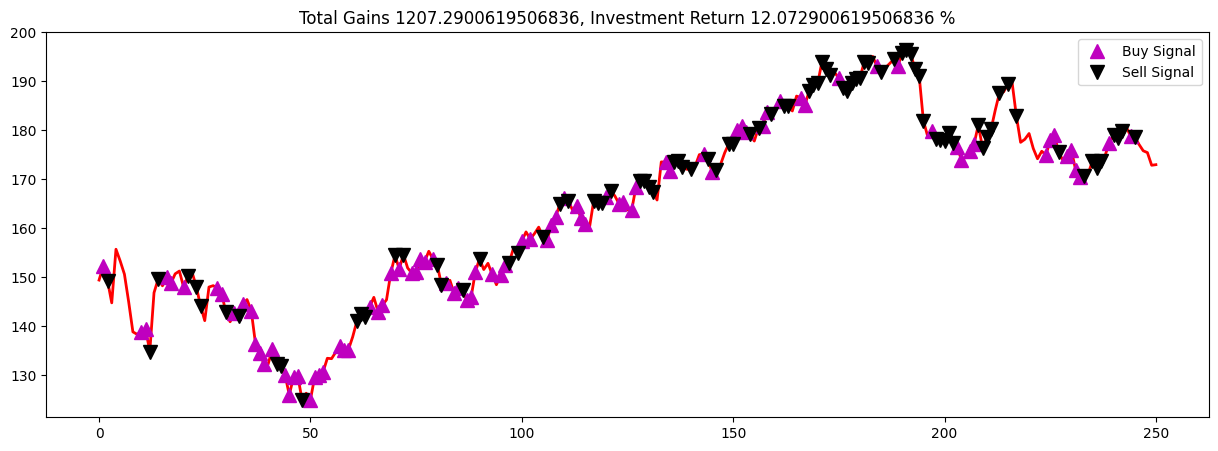

In [30]:
fig = plt.figure(figsize=(15, 5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label='Buy Signal', markevery=states_buy)
plt.plot(close, 'v', markersize=10, color='k', label='Sell Signal', markevery=states_sell)
plt.title(f'Total Gains {total_gains}, Investment Return {invest} %')
plt.legend()
plt.show()


# Trading agent using AI

In [61]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1


In [32]:
class neuralnetwork:
    def __init__(self, id_, hidden_size = 128):
        self.W1 = np.random.randn(window_size, hidden_size) / np.sqrt(window_size)
        self.W2 = np.random.randn(hidden_size, 3) / np.sqrt(hidden_size)
        self.fitness = 0
        self.id = id_

def relu(X):
    return np.maximum(X, 0)

def softmax(X):
    e_x = np.exp(X - np.max(X, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def feed_forward(X, nets):
    a1 = np.dot(X, nets.W1)
    z1 = relu(a1)
    a2 = np.dot(z1, nets.W2)
    return softmax(a2)


In [33]:
class NeuroEvolution:
    def __init__(self, population_size, mutation_rate, model_generator,
                state_size, window_size, trend, skip, initial_money):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.model_generator = model_generator
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money

    def _initialize_population(self):
        self.population = []
        for i in range(self.population_size):
            self.population.append(self.model_generator(i))

    def mutate(self, individual, scale=1.0):
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W1.shape)
        individual.W1 += np.random.normal(loc=0, scale=scale, size=individual.W1.shape) * mutation_mask
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W2.shape)
        individual.W2 += np.random.normal(loc=0, scale=scale, size=individual.W2.shape) * mutation_mask
        return individual

    def inherit_weights(self, parent, child):
        child.W1 = parent.W1.copy()
        child.W2 = parent.W2.copy()
        return child

    def crossover(self, parent1, parent2):
        child1 = self.model_generator((parent1.id+1)*10)
        child1 = self.inherit_weights(parent1, child1)
        child2 = self.model_generator((parent2.id+1)*10)
        child2 = self.inherit_weights(parent2, child2)
        # first W
        n_neurons = child1.W1.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W1[:, cutoff:] = parent2.W1[:, cutoff:].copy()
        child2.W1[:, cutoff:] = parent1.W1[:, cutoff:].copy()
        # second W
        n_neurons = child1.W2.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W2[:, cutoff:] = parent2.W2[:, cutoff:].copy()
        child2.W2[:, cutoff:] = parent1.W2[:, cutoff:].copy()
        return child1, child2

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def act(self, p, state):
        logits = feed_forward(state, p)
        return np.argmax(logits, 1)[0]

    def buy(self, individual):
        initial_money = self.initial_money
        starting_money = initial_money
        state = self.get_state(0)
        inventory = []
        states_sell = []
        states_buy = []

        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(individual, state)
            next_state = self.get_state(t + 1)

            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((self.trend[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, self.trend[t], invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

    def calculate_fitness(self):
        for i in range(self.population_size):
            initial_money = self.initial_money
            starting_money = initial_money
            state = self.get_state(0)
            inventory = []

            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(self.population[i], state)
                next_state = self.get_state(t + 1)

                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    starting_money += self.trend[t]

                state = next_state
            invest = ((starting_money - initial_money) / initial_money) * 100
            self.population[i].fitness = invest

    def evolve(self, generations=20, checkpoint= 5):
        self._initialize_population()
        n_winners = int(self.population_size * 0.4)
        n_parents = self.population_size - n_winners
        for epoch in range(generations):
            self.calculate_fitness()
            fitnesses = [i.fitness for i in self.population]
            sort_fitness = np.argsort(fitnesses)[::-1]
            self.population = [self.population[i] for i in sort_fitness]
            fittest_individual = self.population[0]
            if (epoch+1) % checkpoint == 0:
                print('epoch %d, fittest individual %d with accuracy %f'%(epoch+1, sort_fitness[0],
                                                                          fittest_individual.fitness))
            next_population = [self.population[i] for i in range(n_winners)]
            total_fitness = np.sum([np.abs(i.fitness) for i in self.population])
            parent_probabilities = [np.abs(i.fitness / total_fitness) for i in self.population]
            parents = np.random.choice(self.population, size=n_parents, p=parent_probabilities, replace=False)
            for i in np.arange(0, len(parents), 2):
                child1, child2 = self.crossover(parents[i], parents[i+1])
                next_population += [self.mutate(child1), self.mutate(child2)]
            self.population = next_population
        return fittest_individual


In [68]:
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365 * 0.5)
df_2 = pdr.get_data_yahoo('AAPL', start_date, end_date)
close_2 = df_2.Close.values.tolist()


[*********************100%%**********************]  1 of 1 completed


In [69]:
df_2.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-04-25,165.190002,166.309998,163.729996,163.770004,163.323242,48714100
2023-04-26,163.059998,165.279999,162.800003,163.759995,163.313263,45498800
2023-04-27,165.190002,168.559998,165.190002,168.410004,167.950592,64902300
2023-04-28,168.490005,169.850006,167.880005,169.679993,169.217117,55209200
2023-05-01,169.279999,170.449997,168.639999,169.589996,169.127365,52472900


In [77]:
population_size = 100
generations = 100
mutation_rate = 0.1
neural_evolve = NeuroEvolution(population_size, mutation_rate, neuralnetwork,
                              window_size, window_size, close_2, skip, initial_money)


In [74]:
fittest_nets = neural_evolve.evolve(50)


epoch 5, fittest individual 0 with accuracy 4.490799
epoch 10, fittest individual 0 with accuracy 4.490799
epoch 15, fittest individual 0 with accuracy 4.490799
epoch 20, fittest individual 0 with accuracy 4.528501
epoch 25, fittest individual 0 with accuracy 4.528501
epoch 30, fittest individual 0 with accuracy 4.528501
epoch 35, fittest individual 0 with accuracy 4.528501
epoch 40, fittest individual 0 with accuracy 4.528501
epoch 45, fittest individual 0 with accuracy 4.528501
epoch 50, fittest individual 0 with accuracy 4.528501


In [78]:
states_buy, states_sell, total_gains, invest = neural_evolve.buy(fittest_nets)


day 1: buy 1 unit at price 163.759995, total balance 9836.240005
day 2, sell 1 unit at price 168.410004, investment 2.839527 %, total balance 10004.650009,
day 6: buy 1 unit at price 167.449997, total balance 9837.200012
day 7: buy 1 unit at price 165.789993, total balance 9671.410019
day 8, sell 1 unit at price 173.570007, investment 3.654829 %, total balance 9844.980026,
day 12: buy 1 unit at price 173.750000, total balance 9671.230026
day 14: buy 1 unit at price 172.070007, total balance 9499.160019
day 15, sell 1 unit at price 172.070007, investment 3.787933 %, total balance 9671.230026,
day 16: buy 1 unit at price 172.690002, total balance 9498.540024
day 17, sell 1 unit at price 175.050003, investment 0.748203 %, total balance 9673.590027,
day 18: buy 1 unit at price 175.160004, total balance 9498.430023
day 20: buy 1 unit at price 171.559998, total balance 9326.870026
day 21, sell 1 unit at price 171.839996, investment -0.133673 %, total balance 9498.710022,
day 22: buy 1 unit a

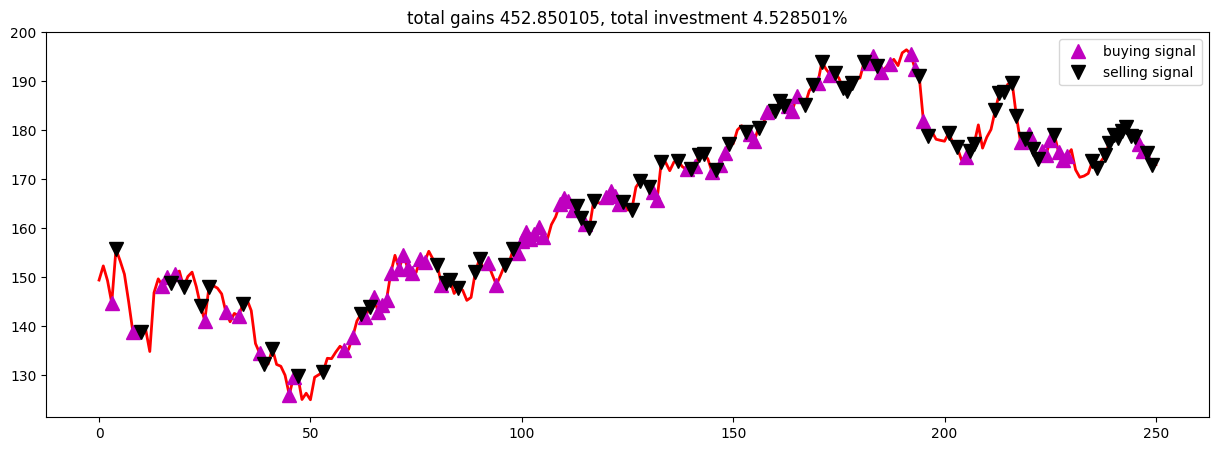

In [76]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()


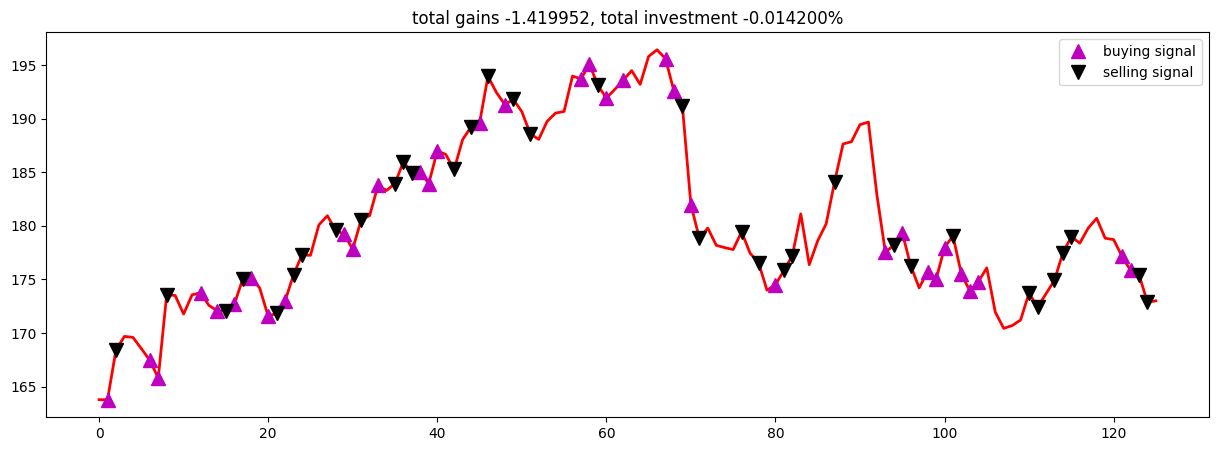

In [79]:
fig = plt.figure(figsize = (15,5))
plt.plot(close_2, color='r', lw=2.)
plt.plot(close_2, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close_2, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()
